Cél: Naponta bontott időjárási adatok letöltése több európai fővárosra 2020 és 2024 között.
A letöltött adatokat egyesítjük, hogy egy közös DataFrame-ben legyenek.
Ez szolgál majd bemenetként a mélytanuló modellhez, amely Budapest jövőbeli hőmérsékletét próbálja majd becsülni.

In [271]:
#pip install scikit-learn

In [272]:
#pip install meteostat

In [273]:
#pip install geopy

In [274]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [275]:
#pip install matplotlib

In [276]:
# Modellparaméterek
HIDDEN_SIZE = 16          # LSTM rejtett réteg mérete
NUM_LAYERS = 1            # LSTM rétegek száma
LEARNING_RATE = 0.001    # Tanulási ráta
BATCH_SIZE = 1024           # Batch méret
N_STEPS = 7               # Rolling window méret (időlépések)
EARLY_STOPPING_PATIENCE = 20
TARGET_CITY = "Budapest"
MAX_RADIUS_KM = 2000
ONLY_CAPITALS = True
RELOAD_CITIES = False
CACHE_VERIFIED = "verified_coordinates.pkl"
CACHE_FAILED = "unresolvable_cities.pkl"

# Célváltozó
TARGET_COLUMN = "Budapest_tmax"

In [277]:
# Standard library
import os
import time
import pickle
from datetime import datetime

# Numerikus, adatelemzés
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Földrajzi távolságok
from geopy.distance import geodesic
from geopy.geocoders import Nominatim

# Időjárás adatok
from meteostat import Point, Daily

# Deep learning - PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [278]:


# SimpleMaps CSV beolvasása
cities_df = pd.read_csv("worldcities.csv")  # Ha máshogy nevezted el, cseréld a fájlnevet

# A célváros kiválasztása
target_row = cities_df[cities_df["city_ascii"] == TARGET_CITY]
if target_row.empty:
    raise ValueError(f"A megadott célváros ({TARGET_CITY}) nem található az adatbázisban.")

target_latlon = (target_row.iloc[0]["lat"], target_row.iloc[0]["lng"])

# Szűrés csak országfővárosokra, ha szükséges
if ONLY_CAPITALS:
    filtered_df = cities_df[cities_df["capital"] == "primary"].copy()
else:
    filtered_df = cities_df.copy()

# Távolság szerinti szűrés
def within_radius(row):
    return geodesic(target_latlon, (row["lat"], row["lng"])).km <= MAX_RADIUS_KM

filtered_df = filtered_df[filtered_df.apply(within_radius, axis=1)]

# Célvárost biztosan hozzáadjuk, ha még nem szerepel
if TARGET_CITY not in filtered_df["city_ascii"].values:
    filtered_df = pd.concat([filtered_df, target_row])

# Koordinátaszótár előállítása
city_coordinates = {
    row["city_ascii"]: (row["lat"], row["lng"]) for _, row in filtered_df.iterrows()
}

print(f"{len(city_coordinates)} város kiválasztva {MAX_RADIUS_KM} km-en belül {TARGET_CITY} körül.")
print(" ->", ", ".join(sorted(city_coordinates.keys())))


52 város kiválasztva 2000 km-en belül Budapest körül.
 -> Algiers, Amsterdam, Andorra la Vella, Ankara, Athens, Belgrade, Berlin, Bern, Bratislava, Brussels, Bucharest, Budapest, Chisinau, Copenhagen, Douglas, Dublin, Helsinki, Kyiv, Ljubljana, London, Luxembourg, Madrid, Minsk, Monaco, Moscow, Nicosia, Oslo, Paris, Podgorica, Prague, Pristina, Riga, Rome, Saint Helier, Saint Peter Port, San Marino, Sarajevo, Skopje, Sofia, Stockholm, Tallinn, The Hague, Tirana, Tripoli, Tunis, Vaduz, Valletta, Vatican City, Vienna, Vilnius, Warsaw, Zagreb


In [279]:

# ==== Beállítások ====


# === Korábbi koordináták betöltése (ha van) ===
if os.path.exists(CACHE_VERIFIED):
    with open(CACHE_VERIFIED, "rb") as f:
        verified_coordinates = pickle.load(f)
    print(f"{len(verified_coordinates)} város koordinátája már korábban letöltve.")
else:
    verified_coordinates = {}

# === Korábban nem található városok betöltése (ha nem akarunk újra próbálkozni) ===
if os.path.exists(CACHE_FAILED) and not RELOAD_CITIES:
    with open(CACHE_FAILED, "rb") as f:
        unresolvable_cities = pickle.load(f)
else:
    unresolvable_cities = set()

# === Geolokátor inicializálása ===
geolocator = Nominatim(user_agent="weather_project")

# === Lekérdezés csak a szükséges városokra ===
for city in city_coordinates.keys():
    if city in verified_coordinates:
        continue  # már lekérdezve
    if not RELOAD_CITIES and city in unresolvable_cities:
        print(f"{city}: korábban nem található, most sem próbáljuk újra.")
        continue
    try:
        location = geolocator.geocode(city + ", Europe")
        if location:
            lat, lon = location.latitude, location.longitude
            verified_coordinates[city] = (lat, lon)
            print(f"{city}: ({lat:.4f}, {lon:.4f})")
        else:
            print(f"{city}: Nem található.")
            unresolvable_cities.add(city)
    except Exception as e:
        print(f"Hiba {city} lekérdezésekor: {e}")
        unresolvable_cities.add(city)
    
    time.sleep(1)

# === Cache mentése ===
with open(CACHE_VERIFIED, "wb") as f:
    pickle.dump(verified_coordinates, f)
with open(CACHE_FAILED, "wb") as f:
    pickle.dump(unresolvable_cities, f)

# === Végeredmény beállítása ===
city_coordinates = verified_coordinates


22 város koordinátája már korábban letöltve.
Ankara: korábban nem található, most sem próbáljuk újra.
Algiers: korábban nem található, most sem próbáljuk újra.
Vienna: korábban nem található, most sem próbáljuk újra.
Warsaw: korábban nem található, most sem próbáljuk újra.
Minsk: korábban nem található, most sem próbáljuk újra.
Copenhagen: korábban nem található, most sem próbáljuk újra.
Helsinki: korábban nem található, most sem próbáljuk újra.
Belgrade: korábban nem található, most sem próbáljuk újra.
Tripoli: korábban nem található, most sem próbáljuk újra.
Zagreb: korábban nem található, most sem próbáljuk újra.
Oslo: korábban nem található, most sem próbáljuk újra.
Chisinau: korábban nem található, most sem próbáljuk újra.
Tallinn: korábban nem található, most sem próbáljuk újra.
Riga: korábban nem található, most sem próbáljuk újra.
Tunis: korábban nem található, most sem próbáljuk újra.
Vilnius: korábban nem található, most sem próbáljuk újra.
The Hague: korábban nem található, 

In [280]:
start = datetime(2000, 1, 1)
end = datetime(2024, 12, 31)

os.makedirs("data", exist_ok=True)
all_data = {}

for name, (lat, lon) in city_coordinates.items():
    file_path = f"data/{name}.csv"
    needs_download = True
    data = None

    if os.path.exists(file_path):
        try:
            data = pd.read_csv(file_path, parse_dates=["time"], index_col="time")
            # Ellenőrizzük, hogy az adatok lefedik-e a kívánt időintervallumot
            if not data.empty:
                min_date, max_date = data.index.min(), data.index.max()
                if min_date <= start and max_date >= end:
                    needs_download = False
                    print(f"{name}: meglévő adat teljes időtartományban.")
                else:
                    print(f"{name}: adat hiányos (elérhető: {min_date.date()} – {max_date.date()}).")
        except Exception as e:
            print(f"{name}: hiba a fájl beolvasásakor, új letöltés. ({e})")

    if needs_download:
        try:
            point = Point(lat, lon)
            data = Daily(point, start, end).fetch()
            data = data[["tavg", "tmin", "tmax", "prcp", "wspd"]]
            data.to_csv(file_path)
            print(f"{name}: adat letöltve és mentve.")
        except Exception as e:
            print(f"{name} adatainak lekérése sikertelen: {e}")
            continue

    data.columns = [f"{name}_{col}" for col in data.columns]
    # Ellenőrizzük, hogy lefedi-e az időtartományt
    if data.index.min() > start or data.index.max() < end:
        print(f"{name}: kihagyva, mert nem teljes az időtartomány ({data.index.min().date()} – {data.index.max().date()})")
        continue  # NE add hozzá az all_data-hoz

    all_data[name] = data

df = pd.concat(all_data.values(), axis=1, join="inner")
df.reset_index(inplace=True)
df.to_csv("european_capitals_weather_combined.csv", index=False)
df.head()


Moscow: meglévő adat teljes időtartományban.
London: meglévő adat teljes időtartományban.
Paris: meglévő adat teljes időtartományban.
Madrid: meglévő adat teljes időtartományban.
Berlin: meglévő adat teljes időtartományban.
Athens: meglévő adat teljes időtartományban.
Kyiv: meglévő adat teljes időtartományban.
Rome: meglévő adat teljes időtartományban.
Bucharest: meglévő adat teljes időtartományban.
Budapest: meglévő adat teljes időtartományban.
Amsterdam: meglévő adat teljes időtartományban.
Sofia: meglévő adat teljes időtartományban.
Prague: meglévő adat teljes időtartományban.
Brussels: meglévő adat teljes időtartományban.
Stockholm: meglévő adat teljes időtartományban.
Dublin: meglévő adat teljes időtartományban.
Skopje: meglévő adat teljes időtartományban.
Tirana: adat hiányos (elérhető: 2000-01-02 – 2024-12-31).
Tirana: adat letöltve és mentve.
Tirana: kihagyva, mert nem teljes az időtartomány (2000-01-02 – 2024-12-31)
Sarajevo: meglévő adat teljes időtartományban.
Bern: adat hiá

,time,Moscow_tavg,Moscow_tmin,Moscow_tmax,Moscow_prcp,Moscow_wspd,London_tavg,London_tmin,London_tmax,London_prcp,...,Sarajevo_tavg,Sarajevo_tmin,Sarajevo_tmax,Sarajevo_prcp,Sarajevo_wspd,Luxembourg_tavg,Luxembourg_tmin,Luxembourg_tmax,Luxembourg_prcp,Luxembourg_wspd
0,2000-01-01,-4.4,-4.9,-3.6,1.5,NaN,9.5,8.9,10.3,1.8,...,9.8,8.6,11.0,NaN,11.4,8.2,7.2,9.8,0.5,6.7
1,2000-01-02,-7.7,-9.0,-7.0,0.3,NaN,9.5,8.0,11.0,NaN,...,NaN,NaN,NaN,NaN,NaN,8.2,6.6,9.2,0.0,7.4
2,2000-01-03,-9.3,-11.0,-9.0,0.2,NaN,9.4,5.6,11.2,2.0,...,NaN,NaN,NaN,NaN,NaN,7.8,6.6,9.6,1.5,11.4
3,2000-01-04,-6.1,-9.1,-2.3,2.5,NaN,6.3,5.0,9.4,3.8,...,10.7,6.6,12.5,NaN,21.3,8.4,6.4,10.8,0.0,19.1
4,2000-01-05,0.1,-2.4,1.4,2.5,NaN,8.1,4.6,11.1,NaN,...,NaN,NaN,NaN,NaN,NaN,7.6,5.9,10.8,4.3,12.5


In [281]:
print("CUDA elérhető:", torch.cuda.is_available())
print("CUDA verzió:", torch.version.cuda)
print("PyTorch build CUDA-támogatással:", torch.backends.cudnn.enabled)
print("Alapértelmezett eszköz:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

CUDA elérhető: True
CUDA verzió: 12.1
PyTorch build CUDA-támogatással: True
Alapértelmezett eszköz: cuda


In [282]:
class WeatherDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # shape: (n, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [283]:


n_steps = N_STEPS  # Hány napos visszatekintés legyen

# Csak a feature-ök, a 'time' oszlop nélkül
raw_features = df.drop(columns=["time"])

# Skálázás DataFrame-ként, hogy később könnyen eldobjuk az oszlopokat
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(raw_features), columns=raw_features.columns)

# NaN-t tartalmazó oszlopok eldobása
cleaned_features = scaled_features.dropna(axis=1)

# Numpy tömb formátumba visszaalakítás
features = cleaned_features.values

# Ellenőrzés
print("Maradt oszlop:", features.shape[1])

# A cél: Budapest tmax
target_column = TARGET_COLUMN
target_series = df[target_column].values[n_steps:]

# Ellenőrizzük, hogy a célváltozó létezik-e
if target_column not in df.columns:
    raise ValueError(f"A megadott célváltozó ({target_column}) nem található a DataFrame-ben!")

# A cél: például "Budapest_tmax" — a teljes oszlopból, rolling window miatt eltolással
target_series = df[target_column].values


# Rolling window input generálás
X = []
y = []

for i in range(n_steps, len(features)):
    X.append(features[i - n_steps:i])
    y.append(target_series[i])  

X = np.array(X)
y = np.array(y)

# Célváltozók ellenőrzése - belefutottunk NaN értékekbe tanulítás során ezért megvizsgáljuk az adatokat
print("Célváltozó (y) statisztika:")
print("Y NaN:", np.isnan(y).any())
print("Y Inf:", np.isinf(y).any())
print("Y max:", np.max(y))
print("Y min:", np.min(y))
print(f"  Szórás: {np.std(y):.4f}")
print(f"  Átlag: {np.mean(y):.4f}")

print("Célváltozó (x) statisztika:")
print("X NaN:", np.isnan(X).any())
print("X Inf:", np.isinf(X).any())
print("X max:", np.max(X))
print("X min:", np.min(X))
print(f"  Szórás: {np.std(X):.4f}")
print(f"  Átlag: {np.mean(X):.4f}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

train_dataset = WeatherDataset(X_train, y_train)
test_dataset = WeatherDataset(X_test, y_test)

# DataLoader-ek
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Maradt oszlop: 48
Célváltozó (y) statisztika:
Y NaN: False
Y Inf: False
Y max: 42.6
Y min: -5.1
  Szórás: 7.7506
  Átlag: 16.9958
Célváltozó (x) statisztika:
X NaN: False
X Inf: False
X max: 22.919412775789798
X min: -3.722916988155856
  Szórás: 1.0000
  Átlag: 0.0007


In [284]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # csak az utolsó időlépés kimenetét használjuk
        out = self.fc(out)
        return out


In [285]:
class EarlyStopping:
    def __init__(self, patience=EARLY_STOPPING_PATIENCE, verbose=True, delta=1e-4):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping: {self.counter}/{self.patience} epoch óta nincs javulás.", end=' ')
            if self.counter >= self.patience:
                self.early_stop = True


In [286]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Modell inicializálás
model = LSTMModel(input_size=X.shape[2], hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS).to(device)


criterion = nn.MSELoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [287]:
early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)
epoch = 0
train_loss_history = []


start_time = time.time()

while epoch < 10000:  # maximum korlát, ha nincs early stop
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)

    train_loss /= len(train_loader.dataset)
    print(f"\nEpoch {epoch+1}, Loss: {train_loss:.4f}", end=' ')
    train_loss_history.append(train_loss)


    early_stopping(train_loss)
    if early_stopping.early_stop:
        print("Korai leállítás aktiválva.")
        break

    epoch += 1

end_time = time.time()
elapsed_time = end_time - start_time  # másodpercben



Epoch 1, Loss: 346.7673 
Epoch 2, Loss: 340.5771 
Epoch 3, Loss: 334.5023 
Epoch 4, Loss: 328.7363 
Epoch 5, Loss: 322.8638 
Epoch 6, Loss: 316.8852 
Epoch 7, Loss: 311.0903 
Epoch 8, Loss: 305.5847 
Epoch 9, Loss: 300.1598 
Epoch 10, Loss: 294.6722 
Epoch 11, Loss: 289.2426 
Epoch 12, Loss: 283.9756 
Epoch 13, Loss: 278.8722 
Epoch 14, Loss: 273.6691 
Epoch 15, Loss: 268.3564 
Epoch 16, Loss: 262.6705 
Epoch 17, Loss: 256.5988 
Epoch 18, Loss: 249.8947 
Epoch 19, Loss: 242.4720 
Epoch 20, Loss: 234.5034 
Epoch 21, Loss: 226.0570 
Epoch 22, Loss: 217.0788 
Epoch 23, Loss: 208.5949 
Epoch 24, Loss: 201.2007 
Epoch 25, Loss: 194.6704 
Epoch 26, Loss: 188.8817 
Epoch 27, Loss: 183.8622 
Epoch 28, Loss: 179.4964 
Epoch 29, Loss: 175.5949 
Epoch 30, Loss: 171.9429 
Epoch 31, Loss: 168.4781 
Epoch 32, Loss: 165.1580 
Epoch 33, Loss: 161.9442 
Epoch 34, Loss: 158.8507 
Epoch 35, Loss: 155.8416 
Epoch 36, Loss: 152.9243 
Epoch 37, Loss: 150.1126 
Epoch 38, Loss: 147.3465 
Epoch 39, Loss: 144.

In [288]:
fname_suffix = f"H{HIDDEN_SIZE}_L{NUM_LAYERS}_LR{LEARNING_RATE}_BS{BATCH_SIZE}_S{N_STEPS}_PAT{EARLY_STOPPING_PATIENCE}"

os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)

csv_path = os.path.join("logs", f"train_loss_{fname_suffix}.csv")
png_path = os.path.join("plots", f"train_loss_{fname_suffix}.png")


In [289]:
pd.DataFrame({
    "epoch": list(range(1, len(train_loss_history) + 1)),
    "train_loss": train_loss_history
}).to_csv(csv_path, index=False)


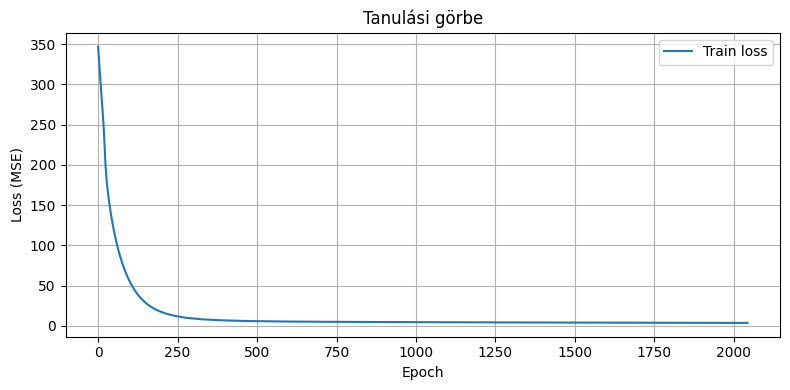

In [290]:


plt.figure(figsize=(8, 4))
plt.plot(train_loss_history, label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Tanulási görbe")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig(png_path)
plt.show()

In [291]:
# === Modell mentése ===
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, f"model_{fname_suffix}.pt")
torch.save(model.state_dict(), model_path)

print(f"Modell mentve: {model_path}")


Modell mentve: models\model_H16_L1_LR0.001_BS1024_S7_PAT20.pt


In [292]:
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).cpu().numpy()
        predictions.extend(outputs.flatten())
        actuals.extend(targets.numpy().flatten())

from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)

print(f"Teszt MSE: {mse:.3f}")
print(f"Teszt MAE: {mae:.3f}")




Teszt MSE: 7.615
Teszt MAE: 2.161


In [293]:


log_file = "training_log.csv"
log_columns = [
    "training", "hidden_size", "learning_rate","layers", "epochs", "batch_size",
    "train_loss", "test_mse", "test_mae", "elapsed_time"
]

if not os.path.exists(log_file):
    pd.DataFrame(columns=log_columns).to_csv(log_file, index=False)

# Naplózás
log_entry = {
    "training": csv_path,
    "hidden_size": HIDDEN_SIZE,
    "learning_rate": LEARNING_RATE,
    "layers" : NUM_LAYERS,
    "epochs" : epoch + 1,
    "batch_size": BATCH_SIZE,
    "train_loss": train_loss,
    "test_mse": mse,
    "test_mae": mae,
    "elapsed_time": round(elapsed_time, 2)  # másodperc, 2 tizedesre kerekítve
}

# Napló hozzáfűzése
log_df = pd.read_csv(log_file)
log_df = pd.concat([log_df, pd.DataFrame([log_entry])], ignore_index=True)
log_df.to_csv(log_file, index=False)